In [1]:
!pip install '/kaggle/input/mmdetectionv2140/pycocotools-2.0.2/pycocotools-2.0.2' --no-deps
#!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Processing /kaggle/input/mmdetectionv2140/pycocotools-2.0.2/pycocotools-2.0.2
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272236 sha256=7dc3e1765f5f7adb9a84a4d7f6d48f4c5119cf5fe4f9efb7f6608952f03b661e
  Stored in directory: /root/.cache/pip/wheels/3b/c9/26/f4ec5e3e2fdc837f5c5539fe16dbe35f82a358c7a4ccca98b4
Successfully built pycocotools


In [2]:
!pip install --no-index ../input/detectron2-offline/detectron2/detectron2-0.6-cp37-cp37m-linux_x86_64.whl --find-links=../input/detectron2-offline/detectron2

Looking in links: ../input/detectron2-offline/detectron2
Processing /kaggle/input/detectron2-offline/detectron2/detectron2-0.6-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/detectron2-offline/detectron2/iopath-0.1.9-py3-none-any.whl
Processing /kaggle/input/detectron2-offline/detectron2/hydra_core-1.1.1-py3-none-any.whl
Processing /kaggle/input/detectron2-offline/detectron2/omegaconf-2.1.1-py3-none-any.whl
Processing /kaggle/input/detectron2-offline/detectron2/black-21.4b2-py3-none-any.whl
Processing /kaggle/input/detectron2-offline/detectron2/fvcore-0.1.5.post20211023-py3-none-any.whl
Processing /kaggle/input/detectron2-offline/detectron2/antlr4_python3_runtime-4.8-py3-none-any.whl
  Attempting uninstall: black
    Found existing installation: black 21.9b0
    Uninstalling black-21.9b0:
      Successfully uninstalled black-21.9b0


In [3]:
#!pip install ../input/detectron-05/whls/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar --no-index --find-links ../input/detectron-05/whls 
#!pip install ../input/detectron-05/whls/fvcore-0.1.5.post20211019/fvcore-0.1.5.post20211019 --no-index --find-links ../input/detectron-05/whls 
#!pip install ../input/detectron-05/whls/antlr4-python3-runtime-4.8/antlr4-python3-runtime-4.8 --no-index --find-links ../input/detectron-05/whls 
#!pip install ../input/detectron-05/whls/detectron2-0.5/detectron2 --no-index --find-links ../input/detectron-05/whls 

In [4]:
import numpy as np 
import pandas as pd
import os
import torch, torchvision
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2
import random
import detectron2
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.utils.logger import setup_logger
from detectron2.evaluation.evaluator import DatasetEvaluator
setup_logger()

<_Logger detectron2 (DEBUG)>

In [5]:
df = pd.read_csv('../input/sartorius-cell-instance-segmentation/train.csv')
df.head()

id                                         annotation  width  \
0  0030fd0e6378  118145 6 118849 7 119553 8 120257 8 120961 9 1...    704   
1  0030fd0e6378  189036 1 189739 3 190441 6 191144 7 191848 8 1...    704   
2  0030fd0e6378  173567 3 174270 5 174974 5 175678 6 176382 7 1...    704   
3  0030fd0e6378  196723 4 197427 6 198130 7 198834 8 199538 8 2...    704   
4  0030fd0e6378  167818 3 168522 5 169225 7 169928 8 170632 9 1...    704   

   height cell_type plate_time sample_date  \
0     520    shsy5y  11h30m00s  2019-06-16   
1     520    shsy5y  11h30m00s  2019-06-16   
2     520    shsy5y  11h30m00s  2019-06-16   
3     520    shsy5y  11h30m00s  2019-06-16   
4     520    shsy5y  11h30m00s  2019-06-16   

                            sample_id elapsed_timedelta  
0  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
1  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
2  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
3  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
4  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00

In [6]:
# Check cell types for latter use in COCO categories
cell_type = pd.unique(df["cell_type"].values.ravel())
print(cell_type)

['shsy5y' 'astro' 'cort']


In [7]:
# Check avaliable image sizes and if they are the same
width = pd.unique(df["width"].values.ravel())
height = pd.unique(df["height"].values.ravel())
print(width, height)

[704] [520]


In [8]:
data_dir=Path('../input/sartorius-cell-instance-segmentation')
ann_file = Path('../input/sartorius-coco/annotations_train.json')
coco = COCO(ann_file)
imgIds = coco.getImgIds()

loading annotations into memory...
Done (t=2.06s)
creating index...
index created!


In [9]:
print(len(imgIds))

485


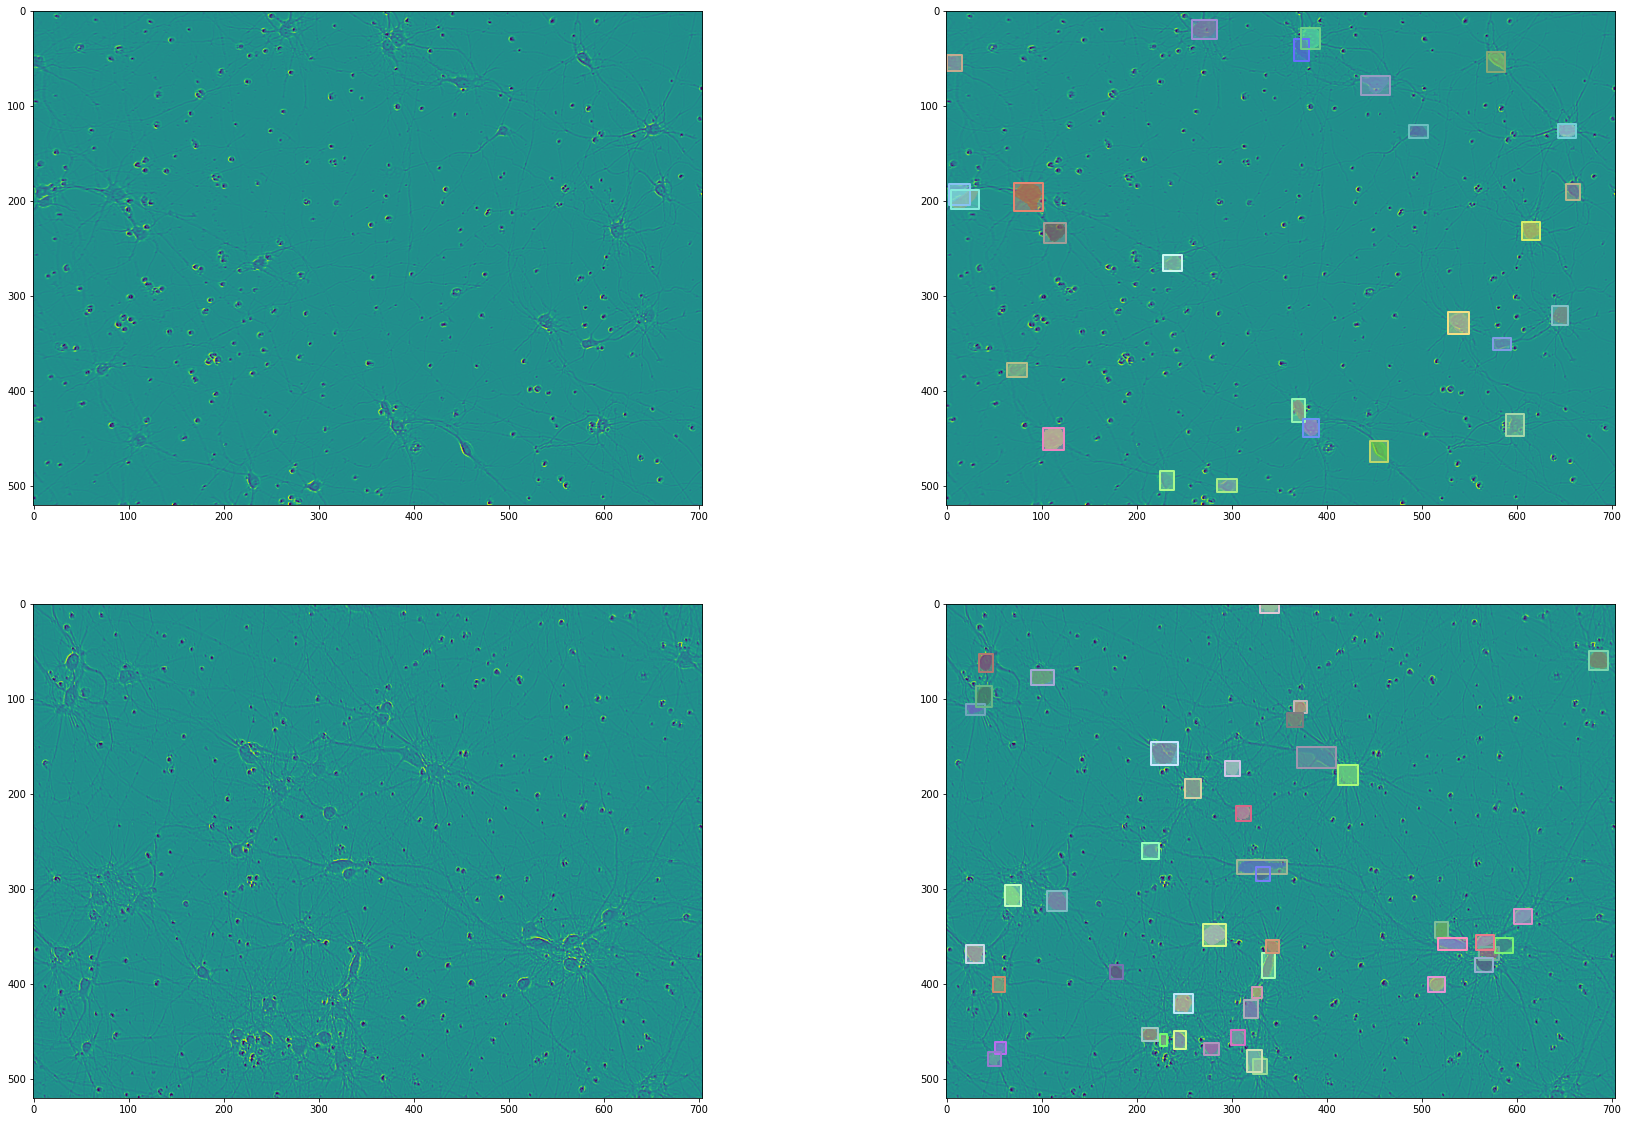

In [10]:
 imgs = coco.loadImgs(imgIds[100:102])
_,axs = plt.subplots(len(imgs),2,figsize=(30,10 * len(imgs)))
for img, ax in zip(imgs, axs):
    I = io.imread(data_dir/img['file_name'])
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)

In [11]:
cfg = get_cfg()
cfg.INPUT.MASK_FORMAT='bitmask'
register_coco_instances('sartorius_cells_train',{}, '../input/sartorius-coco/annotations_train.json', data_dir)
register_coco_instances('sartorius_cells_val',{},'../input/sartorius-coco/annotations_val.json', data_dir)
metadata = MetadataCatalog.get('sartorius_cells_train')
train_ds = DatasetCatalog.get('sartorius_cells_train')

[12/27 14:17:22 d2.data.datasets.coco]: Loading ../input/sartorius-coco/annotations_train.json takes 1.40 seconds.
[12/27 14:17:22 d2.data.datasets.coco]: Loaded 485 images in COCO format from ../input/sartorius-coco/annotations_train.json


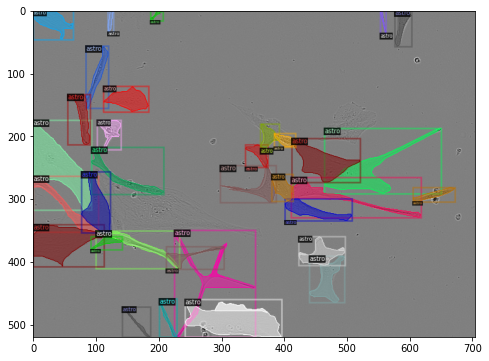

In [12]:
d = train_ds[13]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata)
out = visualizer.draw_dataset_dict(d)
plt.figure(figsize = (10,6))
plt.imshow(out.get_image()[:, :, ::-1])
plt.show()

In [13]:
# Taken from https://www.kaggle.com/theoviel/competition-metric-map-iou
import pycocotools.mask as mask_util

def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}
            
    def reset(self):
        self.scores = []
        
    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)    
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}

class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)

In [14]:
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("sartorius_cells_train",)
cfg.DATASETS.TEST = ("sartorius_cells_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "../input/mask-rcnn-x-101-32x8d-fpn-3x/model_final_2d9806.pkl"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001 
cfg.SOLVER.MAX_ITER = 3000    
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .4
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.7
cfg.TEST.EVAL_PERIOD = len(DatasetCatalog.get('sartorius_cells_train')) // cfg.SOLVER.IMS_PER_BATCH  # Once per epoch

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/27 14:17:25 d2.data.datasets.coco]: Loading ../input/sartorius-coco/annotations_train.json takes 1.34 seconds.
[12/27 14:17:26 d2.data.datasets.coco]: Loaded 485 images in COCO format from ../input/sartorius-coco/annotations_train.json
[12/27 14:17:32 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (b

/opt/conda/lib/python3.7/site-packages/detectron2/data/detection_utils.py:433: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
/opt/conda/lib/python3.7/site-packages/detectron2/data/detection_utils.py:433: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it 

[12/27 14:18:39 d2.utils.events]:  eta: 1:15:48  iter: 19  total_loss: 7.736  loss_cls: 1.27  loss_box_reg: 0.2852  loss_mask: 0.6929  loss_rpn_cls: 4.969  loss_rpn_loc: 0.3361  time: 2.2938  data_time: 1.2135  lr: 1.9981e-05  max_mem: 8732M
[12/27 14:19:15 d2.utils.events]:  eta: 0:58:41  iter: 39  total_loss: 2.946  loss_cls: 1.24  loss_box_reg: 0.4502  loss_mask: 0.6879  loss_rpn_cls: 0.3583  loss_rpn_loc: 0.3016  time: 2.0408  data_time: 0.7303  lr: 3.9961e-05  max_mem: 8732M
[12/27 14:19:48 d2.utils.events]:  eta: 0:57:27  iter: 59  total_loss: 2.746  loss_cls: 0.9354  loss_box_reg: 0.5572  loss_mask: 0.6733  loss_rpn_cls: 0.2955  loss_rpn_loc: 0.2813  time: 1.9055  data_time: 0.6024  lr: 5.9941e-05  max_mem: 8732M
[12/27 14:20:23 d2.utils.events]:  eta: 0:55:31  iter: 79  total_loss: 2.617  loss_cls: 0.8071  loss_box_reg: 0.564  loss_mask: 0.6554  loss_rpn_cls: 0.268  loss_rpn_loc: 0.2849  time: 1.8692  data_time: 0.7219  lr: 7.9921e-05  max_mem: 8732M
[12/27 14:20:56 d2.utils.ev

[12/27 15:53:24 d2.data.datasets.coco]: Loaded 121 images in COCO format from ../input/sartorius-coco/annotations_val.json


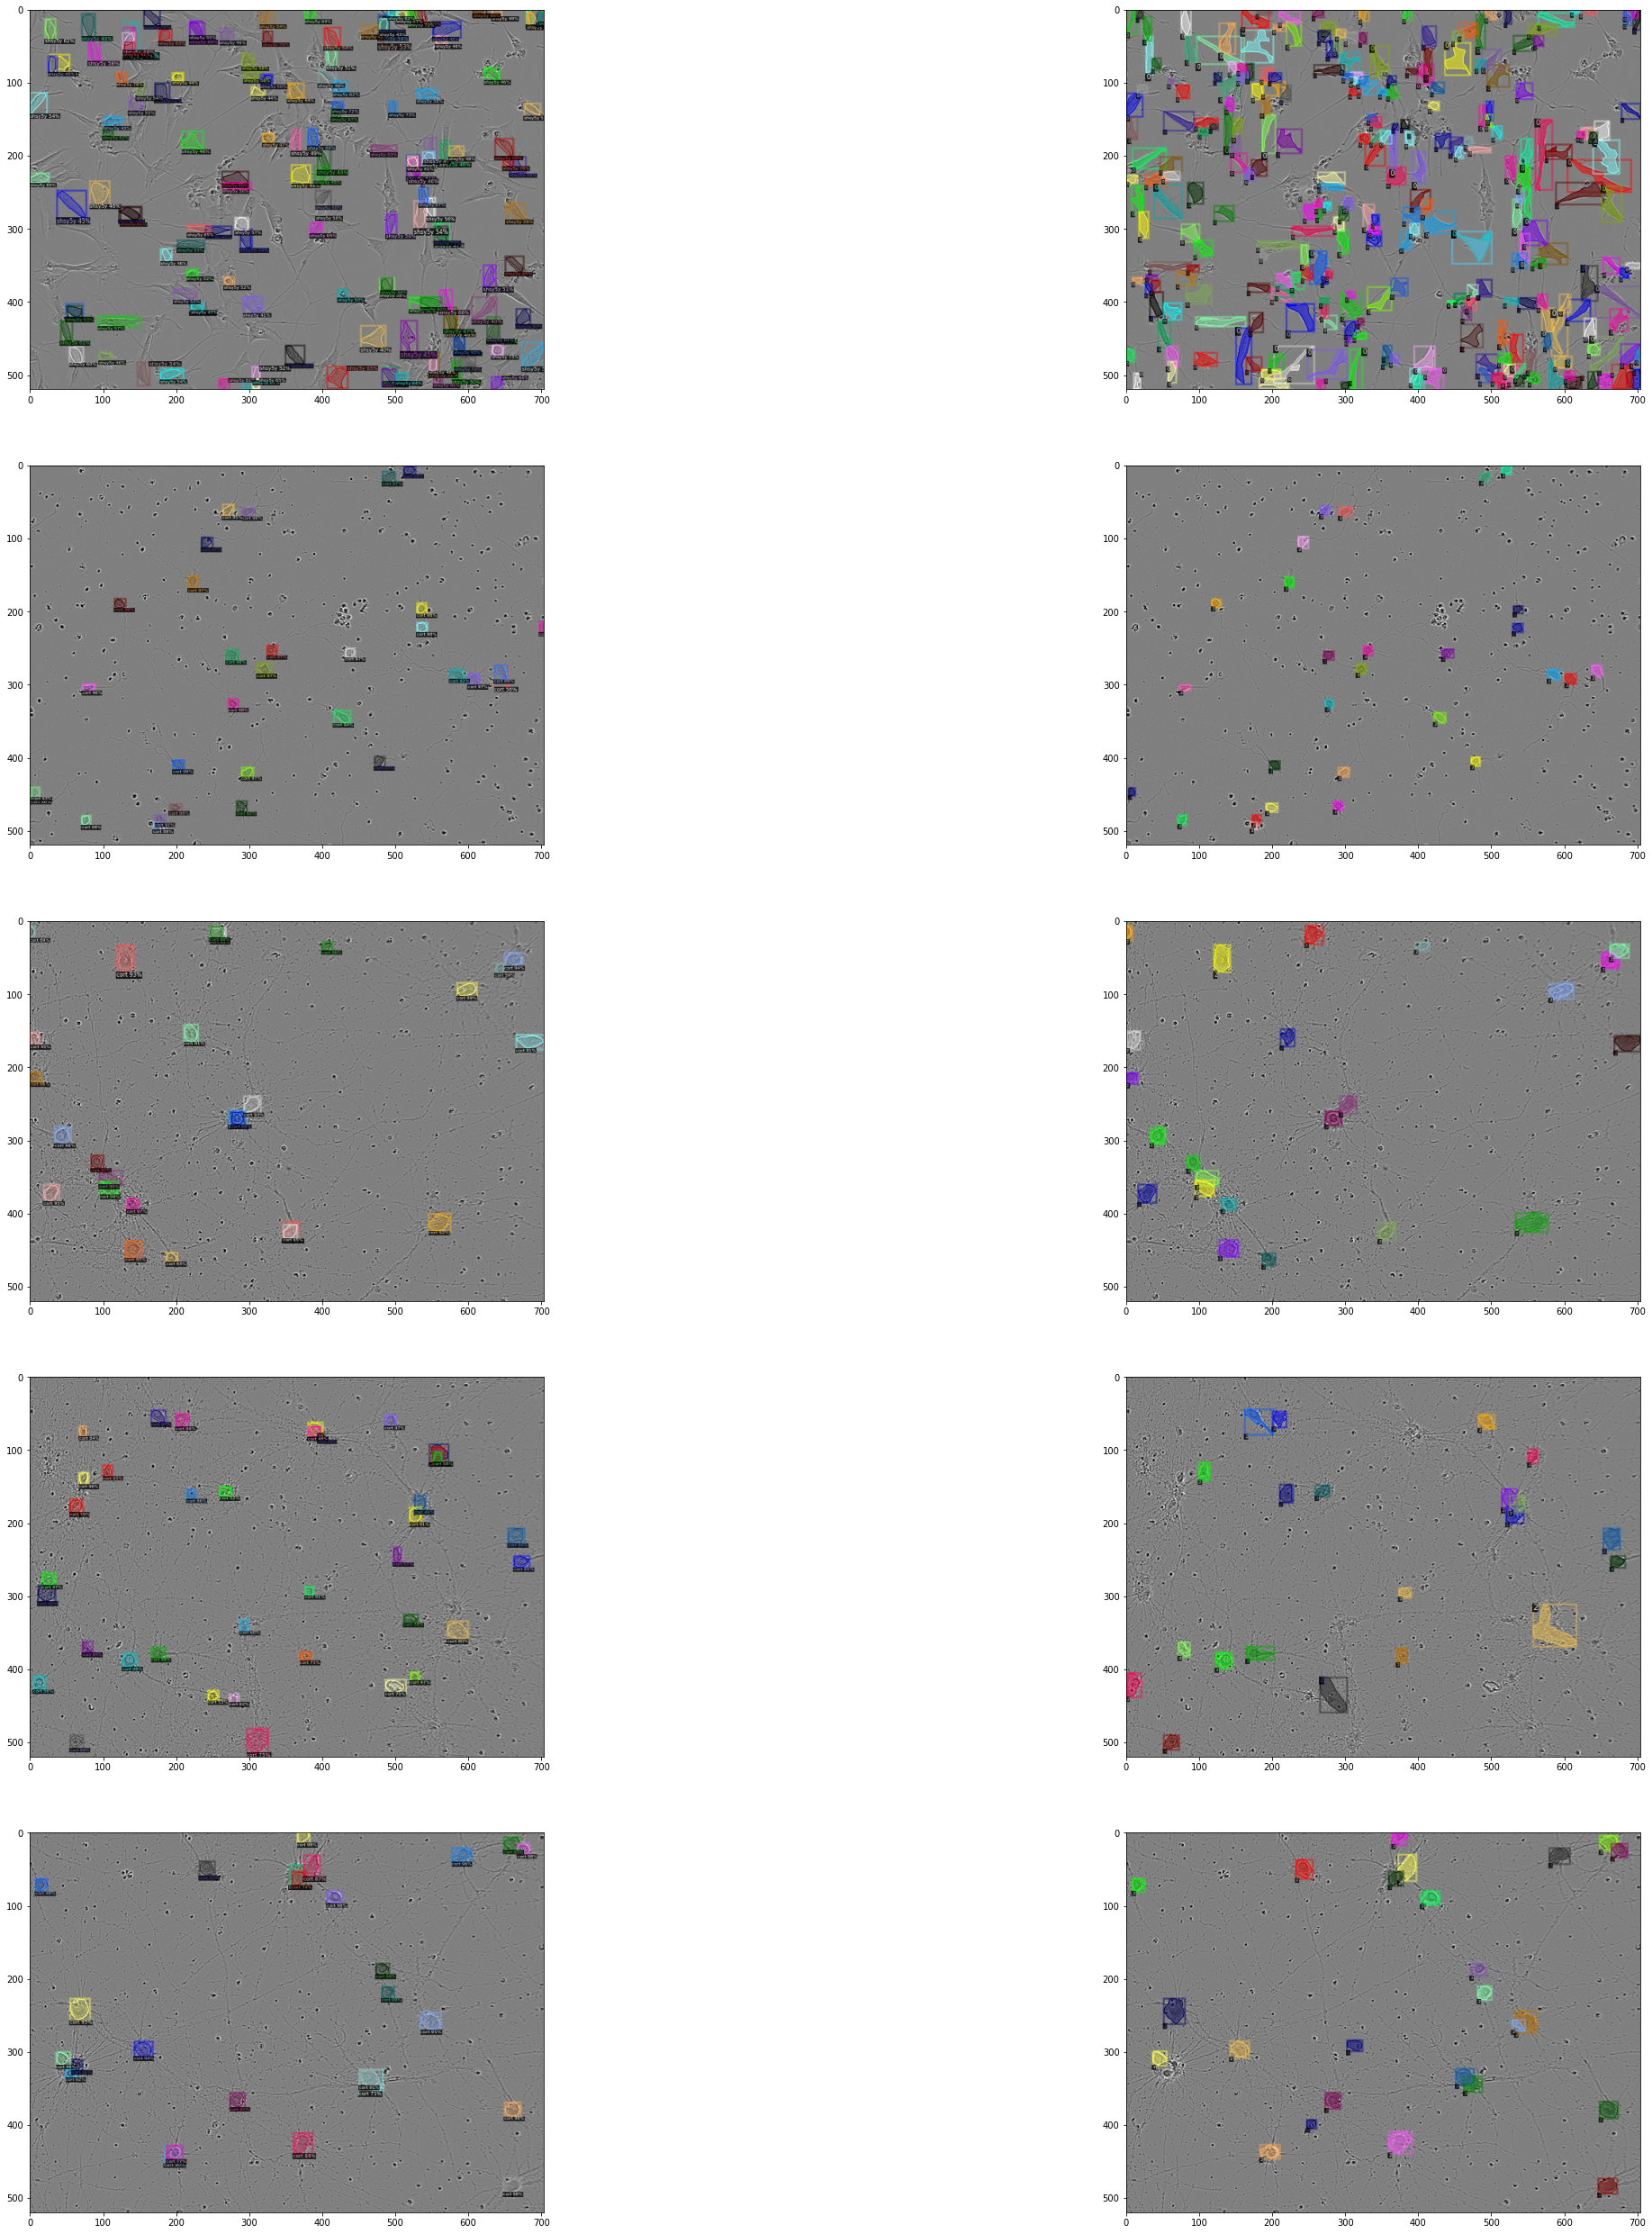

In [15]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  #new model weight 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4
cfg.TEST.DETECTIONS_PER_IMAGE = 1500
predictor = DefaultPredictor(cfg)
dataset_dicts = DatasetCatalog.get('sartorius_cells_val')
outs = []
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata = MetadataCatalog.get('sartorius_cells_train'), 
                    
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels.
    )
    out_pred = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    visualizer = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get('sartorius_train'))
    out_target = visualizer.draw_dataset_dict(d)
    outs.append(out_pred)
    outs.append(out_target)
_,axs = plt.subplots(len(outs)//2,2,figsize=(40,45))
for ax, out in zip(axs.reshape(-1), outs):
    ax.imshow(out.get_image()[:, :, ::-1])
# left - prediction, right - GT